# Project 1: Market Risk — VaR, ES, and Copulas

**Names of all group members:**
- Tellef Skofteland (tellef.skofteland@epfl.ch)
- Felix Reinemo (felix.reinemo@epfl.ch)
- Firstname Lastname (email@example.com)


---

## 0) Setup

Creates necessary folders and sets hyperparameters for the project.

In [32]:
# If a package import fails, install it in your environment, e.g.:
# %pip install yfinance arch copulae statsmodels seaborn

import os
import numpy as np
import copulae
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import statsmodels as sm
from arch import arch_model


# your own script with helper functions, if any
# import utils as U

# Locate the Project 1 directory to this notebook's working directory
PROJECT_DIR = Path.cwd()
DATA_DIR = PROJECT_DIR / 'data'
OUT_DIR = PROJECT_DIR / 'output'
for d in [DATA_DIR, OUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Parameters
TICKERS = ['AAPL', 'META', 'JPM']
START = '2023-01-01'
END = '2025-06-30'
WINDOW = 252                        # rolling/first-window length in periods (days)
ALPHAS = [0.95, 0.99]
np.random.seed(0)

print('Project dir:', PROJECT_DIR)
print('Output ->', OUT_DIR)

Project dir: /Users/Felix/Documents/QRM_project1
Output -> /Users/Felix/Documents/QRM_project1/output


Download and save Adjusted Close for the tickers over the given range into `data/` (CSV per ticker).

In [2]:
import yfinance as yf

print('Downloading data to', DATA_DIR)
for t in TICKERS:
    print(f'  -> {t}')
    df = yf.download(t, start=START, end=END, progress=False, auto_adjust=False)
    if df.empty:
        print(f'     Warning: no data for {t}')
        continue
    out = df.reset_index()
    out = out[['Date', 'Adj Close']]
    out.to_csv(DATA_DIR / f'{t}.csv', index=False)
print('Done.')

  -> AAPL
  -> META
  -> JPM
Done.


Now, load the data back from CSVs

In [3]:
files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith('.csv')]
frames = []
for f in files:
    p = os.path.join(DATA_DIR, f)
    df = pd.read_csv(p, parse_dates=['Date'])
    df = df[['Date', 'Adj Close']]
    # Coerce to numeric and drop malformed rows
    df['Adj Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')
    df = df.dropna(subset=['Date', 'Adj Close'])
    df = df.rename(columns={'Adj Close': f.split('.')[0]})
    df = df.set_index('Date').sort_index()
    frames.append(df)
prices = pd.concat(frames, axis=1).dropna(how='all')

print(prices.head(2))

                  AAPL         JPM        META
Date                                          
2023-01-03  123.211197  125.492233  123.975723
2023-01-04  124.482033  126.662453  126.589607


## 1) Empirical stylized facts


1.  Construct daily log-returns for AAPL, MSFT, JPM; plot series and comment on trends/volatility.
2.  Estimate correlation functions of returns and absolute returns across assets and lags 0–25; comment.
3.  QQ plots vs Normal; perform Jarque–Bera test and discuss normality.


In [4]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

log_returns = np.log(prices / prices.shift(1)).dropna()


fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Scatter(x = log_returns.index, y=log_returns['AAPL'], name="AAPL"), row=1, col=1)
fig.add_trace(go.Scatter(x = log_returns.index, y=log_returns["JPM"], name="JPM"), row=1, col=2)
fig.add_trace(go.Scatter(x = log_returns.index, y=log_returns["META"], name="META"), row=1, col=3)
fig.update_layout(
    title=dict(
        text="Log returns"
    ),
    xaxis=dict(
        title=dict(
            text="Date"
        )
    ),
    yaxis=dict(
        title=dict(
            text="Log returns"
        )
    ),
    legend=dict(

    ),

)
fig.show()

**AAPL:**

The volatility is relatively moderate and consistent over time.

There are occasional spikes in both directions, especially around early 2025, suggesting short-lived periods of increased market activity or news-driven events.

Overall, the series looks to be fairly stable with a positive trend for the returns. 

**JPM:**

The returns seems a lttle bit less volatile than AAPL or META. However, there are several noticeable spikes. The relative calmness for most of the period reflects the generally lower volatility of financial sector stocks compared to tech. 

**META:**

This series shows higher volatility overall, with larger spikes in both positive and negative directions throughout 2023–2025. Tech-sector events could explain these movements. The mean return seems to be positve.  

### b)

In [5]:
import statsmodels.tsa.stattools as smt
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

MAX_LAG = 25

def compute_ccf_matrix(df, max_lag=25, abs_values=False):
    """
    Compute cross-correlation matrix for all pairs of series in df.
    Returns a dictionary {(i,j): array of correlations at lags 0..max_lag}
    """
    if abs_values:
        df = df.abs()
    out = {}
    cols = df.columns
    for i in cols:
        for j in cols:
            ccf_values = smt.ccf(df[i], df[j], adjusted=False)[:max_lag+1]
            out[(i, j)] = ccf_values
    return out

# Compute for raw and absolute returns
ccf_raw = compute_ccf_matrix(log_returns, MAX_LAG)
ccf_abs = compute_ccf_matrix(log_returns, MAX_LAG, abs_values=True)



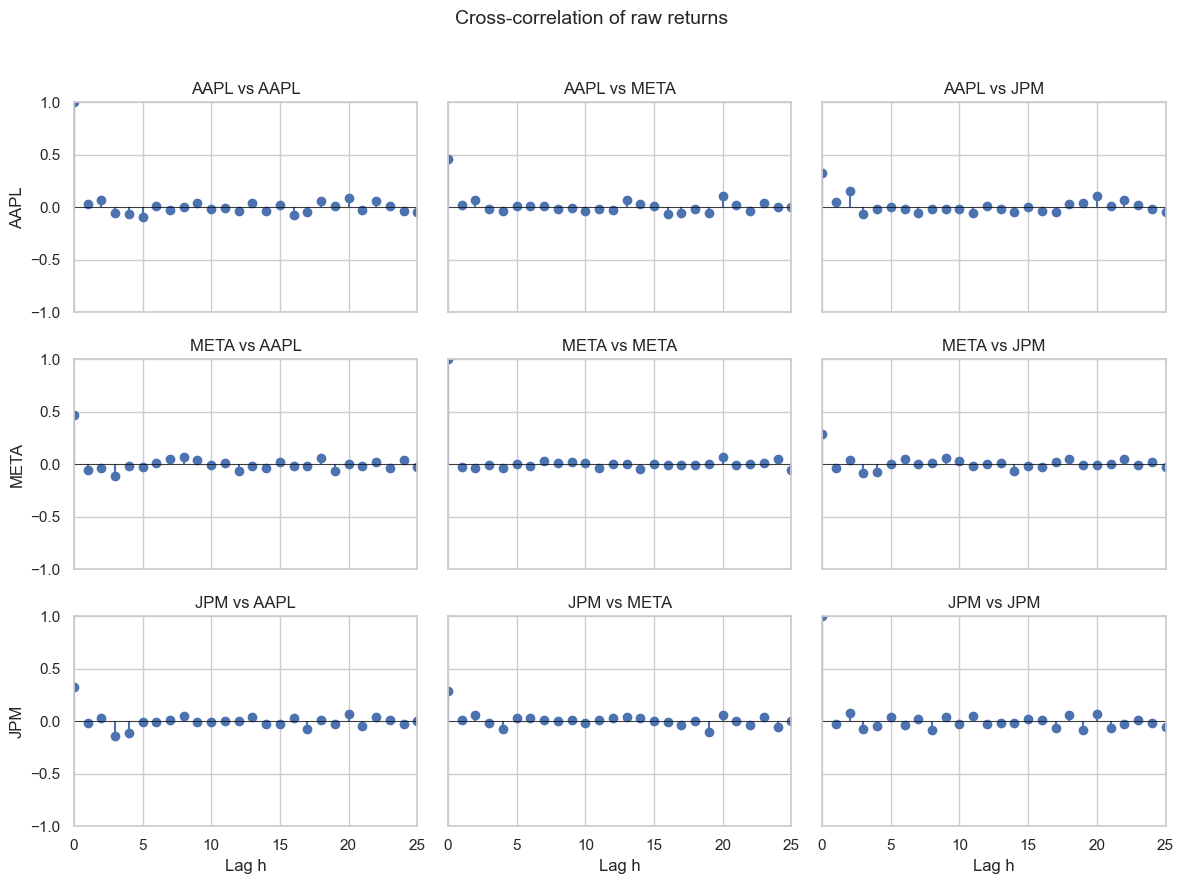

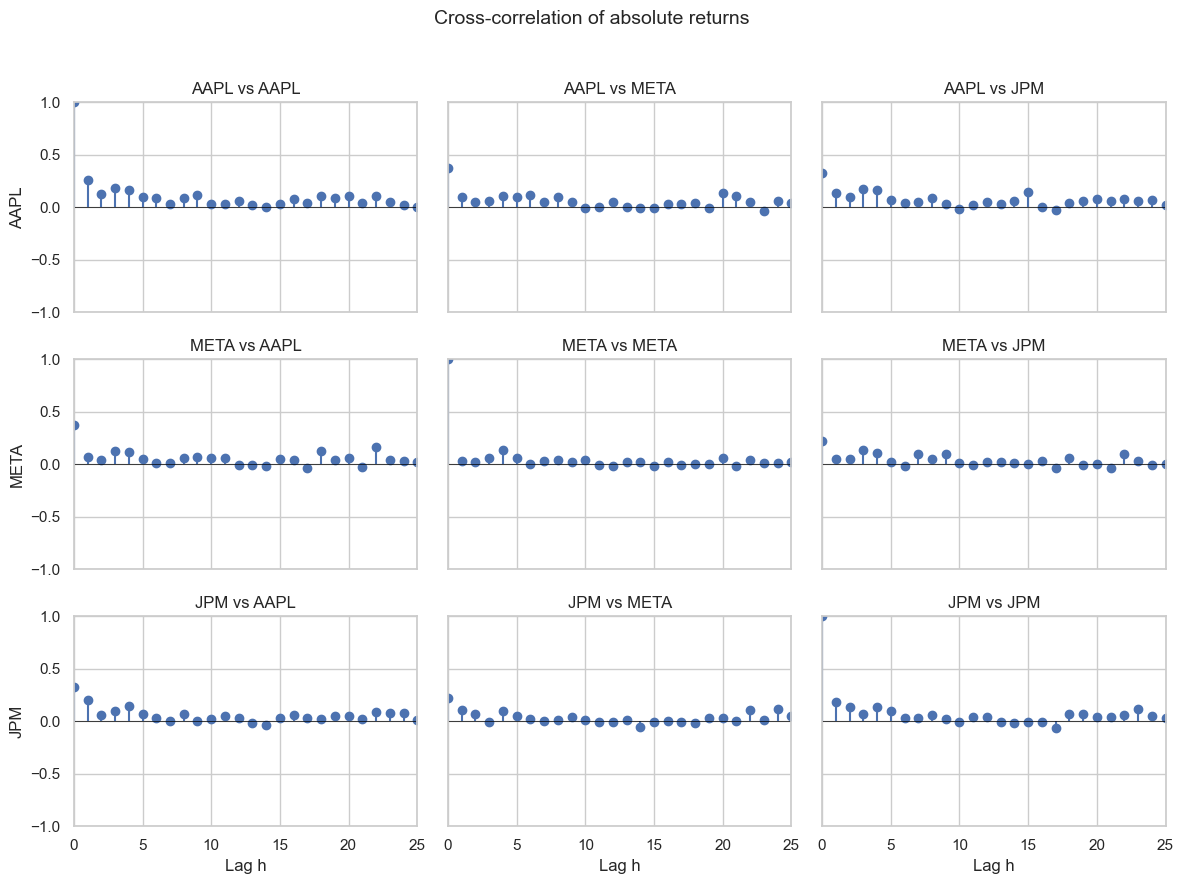

In [6]:
def plot_ccfs(ccf_dict, tickers, max_lag, title):
    k = len(tickers)
    fig, axes = plt.subplots(k, k, figsize=(4*k, 3*k), sharex=True, sharey=True)
    lags = np.arange(0, max_lag+1)
    
    for i, t1 in enumerate(tickers):
        for j, t2 in enumerate(tickers):
            ax = axes[i, j]
            ax.stem(lags, ccf_dict[(t1, t2)], basefmt=" ")
            ax.axhline(0, color='black', lw=0.5)
            ax.set_xlim(0, max_lag)
            ax.set_ylim(-1, 1)
            if i == k-1:
                ax.set_xlabel(f"Lag h")
            if j == 0:
                ax.set_ylabel(f"{t1}")
            ax.set_title(f"{t1} vs {t2}")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot raw and absolute return correlations
tickers = ['AAPL', 'META', 'JPM']
plot_ccfs(ccf_raw, tickers, MAX_LAG, "Cross-correlation of raw returns")
plot_ccfs(ccf_abs, tickers, MAX_LAG, "Cross-correlation of absolute returns")


The autocorrelation and cross-correlation analyses reveal clear volatility clustering at least for AAPL and JPM, as seen from the slow decay of correlations in absolute returns over multiple lags. This indicates persistence in volatility and that periods of market turbulence tend to cluster together. Can't see clear indications of volatility clustering for META. 


The autocorrelations of raw returns are close to zero for $h>0$, suggesting no evidence of linear dependence or serial predictability in daily returns.

The cross-correlations between assets are strongest at lag 0, implying that these stocks tend to move together in response to common information or market shocks. The cross-correlations at nonzero lags are weaker, indicating limited relationships and suggesting that price changes in one market do not systematically drive future changes in another. The exeption seems to be the cross-correlation of absolute returns between JPM and AAPL, which have a slower decay for $h>0$ indicating that their changes is affecting each other over a longer time. 

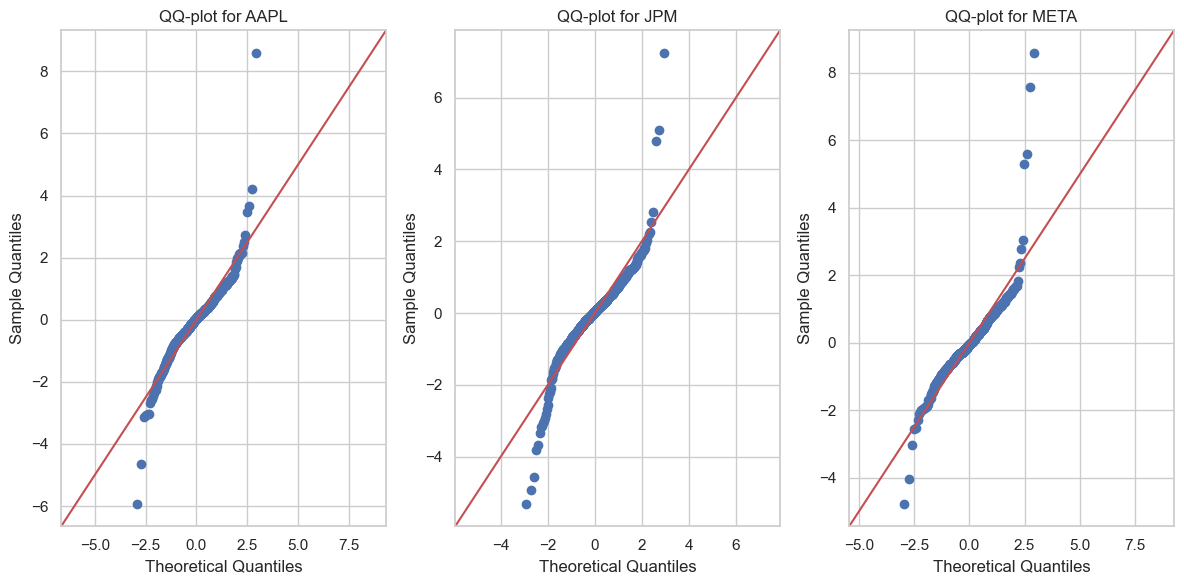

In [7]:
import numpy as np
import statsmodels.api as sm
   
fig, ax = plt.subplots(1, 3, figsize = (12,6))
sm.qqplot(log_returns["AAPL"], line="45", fit=True, ax=ax[0]);
ax[0].set_title("QQ-plot for AAPL")
sm.qqplot(log_returns["JPM"], line="45", fit=True, ax=ax[1]);
ax[1].set_title("QQ-plot for JPM")
sm.qqplot(log_returns["META"], line="45", fit=True, ax=ax[2]);
ax[2].set_title("QQ-plot for META")
fig.set_tight_layout(tight=6)
plt.show()

Based on the QQ-plots of the log-returns above, we can see that they are not normal distributed and that the distribution of the returns have generally much heavier tails than for a normal distribution.


#### Jarque-Bera Test

The Jarque-Bera (JB) test is a statistical test that determines whether a dataset has the skewness and kurtosis matching a normal distribution. 

Test Statistic:
$$
JB = \frac{n}{6} (S^2 + \frac{(K-3)^2}{4})
$$
Where:
n = number of observations
S = sample skewness
K = sample kurtosis


Null hypothesis ($H_0$): The data is normally distributed (skewness = 0 and kurtosis = 3).

Alternative hypothesis ($H_1$): The data is not normally distributed.

Interpretation:

A large JB statistic and a small p-value indicate a rejection of the null hypothesis, suggesting the data does not follow a normal distribution.

A small JB statistic and a high p-value indicate no evidence against normality.

In [8]:
columns = log_returns.columns
JB_list = []
pvalue_list = []
skew_list = []
kurtosis_list = []

# Compute JB test for each column
for col in columns:
    JB, JBpv, skew, kurtosis = sm.stats.stattools.jarque_bera(log_returns[col])
    JB_list.append(JB)
    pvalue_list.append(JBpv)
    skew_list.append(skew)
    kurtosis_list.append(kurtosis)

# Create results table
results_table = pd.DataFrame({
    'JB-value': JB_list,
    'p-value': pvalue_list,
    'Skewness': skew_list,
    'Kurtosis': kurtosis_list
}, index=columns)

print(results_table)

         JB-value  p-value  Skewness   Kurtosis
AAPL  3619.300919      0.0  0.489656  14.776775
JPM   2203.519025      0.0 -0.044780  12.220370
META  7608.774356      0.0  1.865346  19.723280


From the result above we can clearly see that these values aren't normally distributed with a very high test statistic and p-value $\approx 0$ and the high-values of Kurtosis indicates that the distributions has heavier tails. 

## 2) First-window modeling: VaR, ES, and distributions

Use the first estimation window W (days) on each asset separately with losses L = −R.
Compare: 

- historical,
- Gaussian,
- Student-t,
- AR(p)+GARCH(1,1) with Normal/Student-t,
- Filtered Historical Simulation (FHS).

### a) Historical simulation

In [21]:
# TODO
# for the gaussian/student-t fitting, you can use
# stats.norm.fit(data) / stats.t.fit(data)


losses = - log_returns[:252]


def historical(losses, alpha):
   """
   Calculates historical VaR and ES
  
   losses: array-like of losses (L = -R)
   alpha: confidence level
   """
   L = pd.Series(losses).dropna()
   VaR = np.percentile(L, 100 * alpha)
   tail = L[L >= VaR]
   ES = tail.mean()


   return float(VaR), float(ES)

In [22]:
alphas = [0.95, 0.99]
results = []


for stock in losses.columns:
   row = {'Stock': stock}
   for alpha in alphas:
       VaR, ES = historical(losses[stock], alpha)
       row[f'VaR_{int(alpha*100)}'] = VaR
       row[f'ES_{int(alpha*100)}'] = ES
   results.append(row)


summary_df = pd.DataFrame(results)
print(summary_df)

  Stock    VaR_95     ES_95    VaR_99     ES_99
0   JPM  0.018300  0.030295  0.037581  0.047523
1  META  0.027310  0.035920  0.043077  0.044618
2  AAPL  0.017587  0.026807  0.032997  0.040701


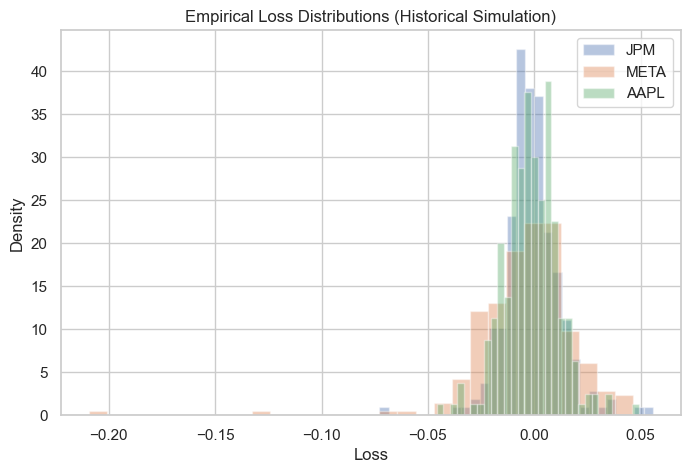

In [23]:
plt.figure(figsize=(8, 5))
for stock in losses.columns:
   plt.hist(losses[stock], bins=30, density=True, alpha=0.4, label=stock)
plt.xlabel("Loss")
plt.ylabel("Density")
plt.title("Empirical Loss Distributions (Historical Simulation)")
plt.legend()
plt.grid(True)
plt.show()

### b) Gaussian

In [24]:
def gaussian(loss, alpha):
   """
   Calculates Gaussian VaR and ES
  
   loss: array-like of losses (L = -R)
   alpha: confidence level
   """


   L = pd.Series(loss).dropna()
   mu_L, sigam_L = stats.norm.fit(L)
   z = stats.norm.ppf(alpha)
  
   VaR = mu_L + sigam_L * z
   ES = mu_L + sigam_L * stats.norm.pdf(z) / (1 - alpha)


   return float(VaR), float(ES), mu_L, sigam_L

In [25]:
gauss_results = []
for stock in losses.columns:
   row = {'Stock': stock}
   for alpha in alphas:
       VaR, ES, mu_L, sigma_L = gaussian(losses[stock], alpha)
       row[f'VaR_{int(alpha*100)}'] = VaR
       row[f'ES_{int(alpha*100)}'] = ES
   row['Mu_L'] = mu_L
   row['Sigma_L'] = sigma_L
   gauss_results.append(row)


gaussian_summary = pd.DataFrame(gauss_results)
print(gaussian_summary)

  Stock    VaR_95     ES_95    VaR_99     ES_99      Mu_L   Sigma_L
0   JPM  0.020292  0.025723  0.029149  0.033553 -0.001085  0.012996
1  META  0.035232  0.045215  0.051512  0.059608 -0.004061  0.023889
2  AAPL  0.019421  0.024738  0.028092  0.032404 -0.001509  0.012724


### c) Student-t:

In [26]:
def student_t(loss, alpha):
   """
   Calculates Student-t VaR and ES
  
   loss: array-like of losses (L = -R)
   alpha: confidence level
   """


   L = pd.Series(loss).dropna()
   df, mu_L, sigma_L = stats.t.fit(L, floc=0)
   t_alpha = stats.t.ppf(alpha, df)
  
   VaR = mu_L + sigma_L * t_alpha
   ES = mu_L + (sigma_L * (df + t_alpha**2) / (df - 1)) * stats.t.pdf(t_alpha, df) / (1 - alpha)


   return float(VaR), float(ES), mu_L, sigma_L, df

In [28]:
t_results = []
for stock in losses.columns:
   row = {'Stock': stock}
   for alpha in alphas:
       VaR, ES, mu_L, sigma_L, df = student_t(losses[stock], alpha)
       row[f'VaR_{int(alpha*100)}'] = VaR
       row[f'ES_{int(alpha*100)}'] = ES
   row['Mu_L'] = mu_L
   row['Sigma_L'] = sigma_L
   row['DF'] = df
   t_results.append(row)


student_t_summary = pd.DataFrame(t_results)
print(student_t_summary)

  Stock    VaR_95     ES_95    VaR_99     ES_99  Mu_L   Sigma_L        DF
0   JPM  0.019720  0.029876  0.034972  0.049182     0  0.009161  3.870275
1  META  0.032972  0.048780  0.056993  0.078056     0  0.015750  4.272000
2  AAPL  0.020558  0.028166  0.032544  0.040939     0  0.010846  6.978466


### d) Conditional parametric:

In [31]:
def fit_ar_garch(losses, p):


   x = pd.Series(losses).dropna()


   am = arch_model(x, vol='Garch', p=1, q=1, dist='normal', mean='AR', lags=p, rescale=False)
   res = am.fit(disp='off')


   return res


def forecast_ar_garch(res, alpha):


   forecast = res.forecast(horizon=1)


   mu_L = forecast.mean.iloc[-1, 0]
   sigma_L = np.sqrt(forecast.variance.iloc[-1, 0])


   z = stats.norm.ppf(alpha)
   VaR = mu_L + sigma_L * z
   ES = mu_L + sigma_L * stats.norm.pdf(z) / (1 - alpha)


   return float(VaR), float(ES), mu_L, sigma_L


def ar_garch(losses, p, alpha):


   res = fit_ar_garch(losses, p)
   VaR, ES, mu_L, sigma_L = forecast_ar_garch(res, alpha)
  
   return float(VaR), float(ES), mu_L, sigma_L

In [33]:
p = 0 #???


ar_garch_results = []
for stock in losses.columns:
  row = {'Stock': stock}
  for alpha in alphas:
      VaR, ES, mu_L, sigma_L = ar_garch(losses[stock], p, alpha)
      row[f'VaR_{int(alpha*100)}'] = VaR
      row[f'ES_{int(alpha*100)}'] = ES
  row['Mu_L'] = mu_L
  row['Sigma_L'] = sigma_L
  ar_garch_results.append(row)


ar_garch_summary = pd.DataFrame(ar_garch_results)
print(ar_garch_summary)

  Stock    VaR_95     ES_95    VaR_99     ES_99      Mu_L   Sigma_L
0   JPM  0.013769  0.017645  0.020090  0.023234 -0.001489  0.009276
1  META  0.031960  0.040969  0.046653  0.053959 -0.003502  0.021560
2  AAPL  0.019642  0.025005  0.028389  0.032738 -0.001470  0.012835


### d) Filtered historical simulation:

In [35]:
def fhs(res, alpha, M):


   rng = np.random.default_rng(0)


   std_resid = res.resid / res.conditional_volatility
   std_resid = std_resid.dropna().to_numpy()


   forecast = res.forecast(horizon=1)
   mu = float(forecast.mean.iloc[-1, 0])
   sigma = float(np.sqrt(forecast.variance.iloc[-1, 0]))
  
   z = rng.choice(std_resid, size=M, replace=True)


   simulated_losses = mu + sigma * z


   VaR = np.percentile(simulated_losses, 100 * alpha)
   ES = simulated_losses[simulated_losses >= VaR].mean()


   return float(VaR), float(ES), simulated_losses

In [36]:
M = 1000


fhs_results = []
for stock in losses.columns:
  row = {'Stock': stock}
  res = fit_ar_garch(losses[stock], p)
  for alpha in alphas:
      VaR, ES, _ = fhs(res, alpha, M)
      row[f'VaR_{int(alpha*100)}'] = VaR
      row[f'ES_{int(alpha*100)}'] = ES
  fhs_results.append(row)


fhs_summary = pd.DataFrame(fhs_results)
print(fhs_summary)

  Stock    VaR_95     ES_95    VaR_99     ES_99
0   JPM  0.015034  0.023541  0.032830  0.037251
1  META  0.023794  0.029585  0.035498  0.037153
2  AAPL  0.019915  0.030714  0.036668  0.045701


### Plotting distributions:

In [38]:
def plot_loss_distributions(stock,
                           L,
                           mu_g, sigma_g,            # Gaussian parameters
                           df_t, mu_t, sigma_t,      # Student-t parameters
                           fhs_sim_losses=None,      # Optional: simulated FHS losses
                           bins=40):


   L = pd.Series(L).dropna()

   # x-range covering all methods
   xs = np.linspace(
       min(L.min(), np.percentile(fhs_sim_losses, 0.1) if fhs_sim_losses is not None else L.min()) * 1.2,
       max(L.max(), np.percentile(fhs_sim_losses, 99.9) if fhs_sim_losses is not None else L.max()) * 1.2,
       800
   )
  
   # PDFs
   kde = stats.gaussian_kde(L)          # empirical density
   pdf_emp = kde(xs)
   pdf_g = stats.norm.pdf(xs, loc=mu_g, scale=sigma_g)
   pdf_t = stats.t.pdf(xs, df=df_t, loc=mu_t, scale=sigma_t)


  
   if fhs_sim_losses is not None:
       kde_fhs = stats.gaussian_kde(fhs_sim_losses)
       pdf_fhs = kde_fhs(xs)
   else:
       pdf_fhs = None
  
   # Plot
   plt.figure(figsize=(9,5))


   # Empirical density
   #plt.plot(xs, pdf_emp, label="Empirical (KDE)", linewidth=2)
   plt.hist(L, bins=40, density=True, alpha=0.25, color="gray", label="Histogram")




   # Gaussian
   plt.plot(xs, pdf_g, label="Gaussian fit", linestyle='--')


   # Student-t
   plt.plot(xs, pdf_t, label=f"Student-t fit (df={df_t:.1f})", linestyle='-.')


   # FHS
   if pdf_fhs is not None:
       plt.plot(xs, pdf_fhs, label="Filtered Historical Simulation", linestyle=':')


   plt.title(f"Comparison of Loss Distributions – {stock}")
   plt.xlabel("Loss")
   plt.ylabel("Density")
   plt.grid(True, alpha=0.3)
   plt.legend()
   plt.show()


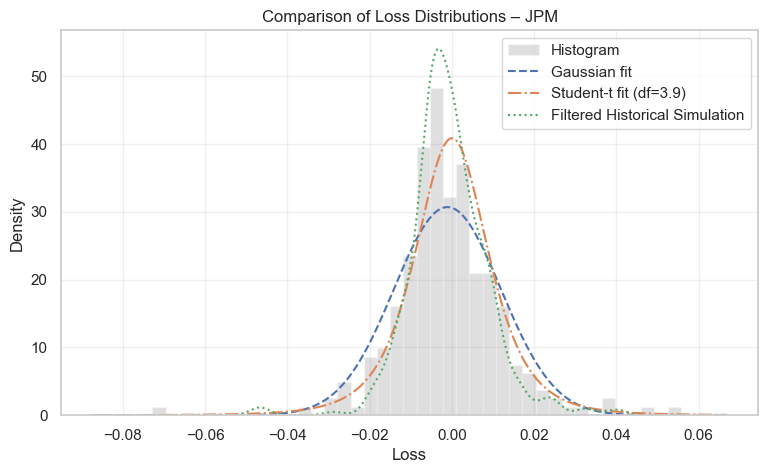

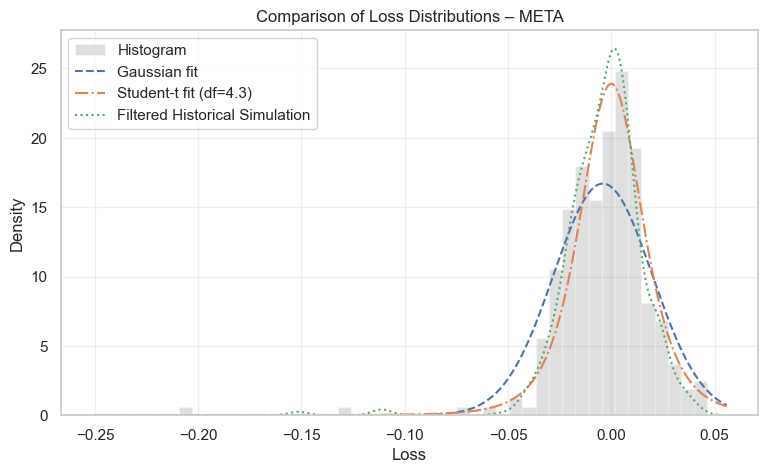

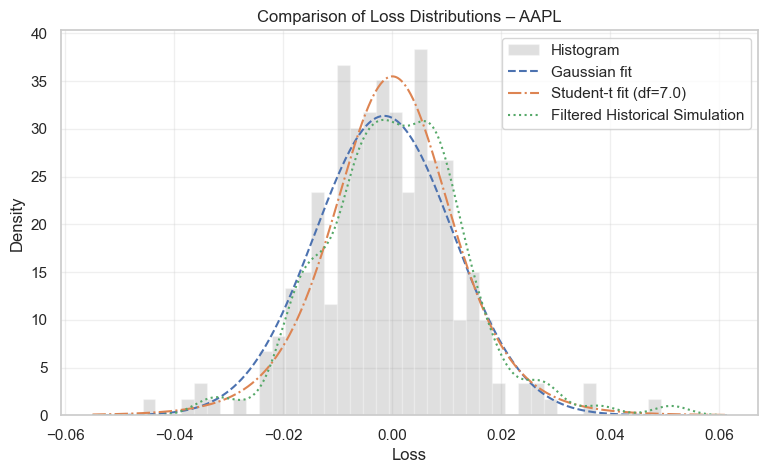

In [39]:
for stock in losses.columns:
   L = losses[stock]


   # Gaussian fit
   #mu_g, sigma_g = stats.norm.fit(L)
   _, _, mu_g, sigma_g = gaussian(L, 0.95) 


   # Student-t fit
   #nu_t, mu_t, sigma_t = stats.t.fit(L)
   _, _, mu_t, sigma_t, df_t = student_t(L, 0.95)


   # FHS simulated losses
   res = fit_ar_garch(L, p=1)
   _, _, fhs_sim = fhs(res, 0.95, M=1000)
  
   plot_loss_distributions(
       stock,
       L,
       mu_g, sigma_g,
       df_t, mu_t, sigma_t,
       fhs_sim_losses=fhs_sim
   )


## 3) Rolling-window backtesting of VaR and ES

Use a rolling window of size W to produce 1-step-ahead VaR/ES at 95% and 99% for each method in Exercise 2. Then, implement the following statistical tests:

- VaR backtests: Kupiec POF and Christoffersen independence tests.
- ES backtest: Acerbi–Székely Z1 test.

In [10]:
# TODO

# Unfortunately, it seems like there is no direct implementation of such tests in Python.
# Look better into this, or implement them yourself.

## 4) Copula fitting (first window)

1. Visualize dependence in returns and copula space using pseudo-observations.
2. Fit Gaussian and t copulas; report parameters.
3. Simulate from fitted copulas and map to empirical marginals; compare with original returns.

In [11]:
# TODO

# Use copulae package for copula fitting and sampling
# cop = copulae.elliptical.GaussianCopula(dim=len(TICKERS))
# cop.fit(data)
# samples = cop.random(n)

## 5) Portfolio VaR/ES with copulas (rolling)

Equal-weighted portfolio of AAPL, MSFT, JPM. Compare univariate models (as in Exercise 3) vs copula-based VaR/ES with rolling windows.

At each time, fit copulas on last W days, simulate N scenarios, estimate VaR/ES from simulated portfolio returns, then backtest.

In [12]:
# TODO